# Selección y extracción de atributos
**Autor:** José A. Troyano &nbsp;&nbsp;&nbsp; **Revisor:** Beatriz Pontes  &nbsp;&nbsp;&nbsp; **Última modificación:** 21/01/2019

## Contenido

1. <a href="#univariante">Selección univariante</a> <br>
    1.1 <a href="#anova">Test ANOVA</a> <br>
    1.2 <a href="#otros">Otros tests disponibles en Sklearn</a>
2. <a href="#estimadores">Selección de atributos basada en estimadores</a><br>
    2.1 <a href="#arboles">Mediante árboles</a><br>
    2.2 <a href="#coeficientes">Mediante coeficientes de modelos lineales</a><br>
    2.3 <a href="#pipelines">Pipelines para encadenar selección y clasificación</a><br>
3. <a href="#pca">Extracción de atributos mediante análisis de componentes principales</a><br>
4. <a href="#rfe">Selección de atributos por eliminación recursiva</a><br>
5. <a href="#conclusiones">Conclusiones</a>
------------------------------------------------------

En este notebook veremos cómo reducir el número de atributos de nuestro dataset. Lucharemos con lo que se conoce como _curse of dimensionality_ que tiene básicamente estos efectos:
- Cuando aumenta la dimensionalidad, el volumen del espacio aumenta exponencialmente haciendo que los datos disponibles se vuelven dispersos. 
- Esta dispersión impide que los algoritmos de aprendizaje puedan construir buenos modelos.

La selección y extracción de atributos son dos estrategias típicas para luchar con la maldición de la dimensionalidad. Se basan, respectivamente, en la elección de un buen subconjunto de atributos y en la construcción de nuevos atributos a partir de los originales.

Empezaremos por importar todos los elementos que usaremos a lo largo del notebook:

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

Usaremos el dataset _breast-cancer_, disponible en Sklearn que tiene:
- 569 instancias
- 30 atributos numéricos

Para asegurarnos que hay atributos que deben ser eliminados crearemos una versión ofuscada de este dataset con 30 columnas aleatorias. Esta versión presenta, por tanto, estos números:
- 569 instancias
- 60 atributos numéricos

Si quisiésemos probar todas los posibles subconjuntos de 60 atributos para encontrar el mejor, tendríamos que probar $2^{60}$ combinaciones, que nos da un total de $11 \times 10^{17}$ experimentos. Si cada experimento durase un segundo, tendríamos que esperar 36.000 millones de años para ejecutarlos todos. Gracias a la selección y extracción de atributos tenemos estrategias para encontrar un buen conjunto de atributos (no el mejor) en un tiempo razonable.

In [2]:
# Empezaremos por leer el dataset desde Sklearn y crear 'X' e 'y'
datos = load_breast_cancer()
X = pd.DataFrame(datos['data'], columns=datos['feature_names'])
y = pd.Series(datos['target'])
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [3]:
# Generaremos una matriz 'X_ruidosos' que contenga las columnas de 'X' junto con 30 columnas aleatorias
generador_ruido = np.random.RandomState(0)
datos_ruidosos = generador_ruido.normal(size=(len(X), 30))
nombres = ['R-'+str(i) for i in range(30)]
datos_ruidosos = pd.DataFrame(datos_ruidosos, columns=nombres)
X_ruidosos = pd.concat([X, datos_ruidosos], axis=1)
print(X_ruidosos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 60 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

Y ahora evaluamos ambos datasets para tener así una referencia del erfecto de las distintas técnicas de selección de atributos que vamos a probar:

In [4]:
# Evaluamos ambos datasets para tener los baselines
def evalua(X, y, clasificador=LogisticRegression(solver='liblinear')):
    ''' Función para evaluar un dataset mediante validación cruzada
    
    Por defecto se usa el clasificador LogisticRegression, aunque se puede cambiar.
    '''
    scores = cross_val_score(clasificador, X, y, cv=10)
    return scores.mean()

print(evalua(X,y))
print(evalua(X_ruidosos,y))

0.9491454930429521
0.9331669691470056


En la siguiente celda se incluyen un par de funciones que nos ayudarán a interpretar los resultados de las distintas técnicas de selección de atributos que vamos a usar:

In [5]:
def muestra_relevancias(nombres, relevancias):
    '''Función para mostrar una gráfica con el grado de relevancia de cada atributo
    
    Recibe:
       - nombres: nombres de todos los atributos
       - relevancias: de cada atributo, calculadas mediante alguna técnica
    '''
    plt.figure(figsize=(len(nombres)/4,5))
    serie = pd.Series(relevancias, index=nombres)
    serie.plot(kind='bar')
    
def muestra_seleccion(nombres, mascara):
    '''Función para mostrar los nombres de los atributos seleccionados a partir de una máscara de booleanos
    
    Recibe:
       - nombres: nombres de todos los atributos
       - mascara: lista de booleanos que determina si un atributo se selecciona, o no
    '''    
    seleccionados = [n for n,m in zip(nombres, mascara) if m]
    print(len(seleccionados), seleccionados)

## 1. Selección univariante <a name="univariante"> </a>

En esta sección veremos formas de valorar qué importancia tiene cada atributo de forma individual. Para ello nos apoyaremos en tests estadísticos que miden la relación de cada atributo con la clase a predecir (o valor numérico en caso de regresión).


### 1.1. Test ANOVA <a name="anova"> </a>

(array([6.46981021e+02, 1.18096059e+02, 6.97235272e+02, 5.73060747e+02,
       8.36511234e+01, 3.13233079e+02, 5.33793126e+02, 8.61676020e+02,
       6.95274435e+01, 9.34592949e-02, 2.68840327e+02, 3.90947023e-02,
       2.53897392e+02, 2.43651586e+02, 2.55796780e+00, 5.32473391e+01,
       3.90144816e+01, 1.13262760e+02, 2.41174067e-02, 3.46827476e+00,
       8.60781707e+02, 1.49596905e+02, 8.97944219e+02, 6.61600206e+02,
       1.22472880e+02, 3.04341063e+02, 4.36691939e+02, 9.64385393e+02,
       1.18860232e+02, 6.64439606e+01]), array([8.46594057e-096, 4.05863605e-025, 8.43625104e-101, 4.73456431e-088,
       1.05185036e-018, 3.93826311e-056, 9.96655576e-084, 7.10115016e-116,
       5.73338403e-016, 7.59936804e-001, 9.73894866e-050, 8.43332029e-001,
       1.65190518e-047, 5.89552139e-046, 1.10296609e-001, 9.97599465e-013,
       8.26017617e-010, 3.07230877e-024, 8.76641818e-001, 6.30735508e-002,
       8.48229192e-116, 1.07805749e-030, 5.77139714e-119, 2.82884770e-097,
       6.57

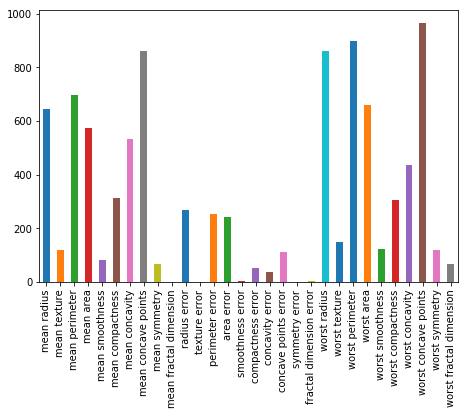

In [6]:
# EJERCICIO: mostrar el grado de relevancia de cada atributo del datastet X mediante el test ANOVA
t_anova = f_classif(X, y)
#devuelve dos arrays, el primero son las relevancias que es lo que nos interesa y el segundo es el nivel de confianza de los resultados obtenidos (p_values)
print(t_anova)
muestra_relevancias(X.columns,t_anova[0])

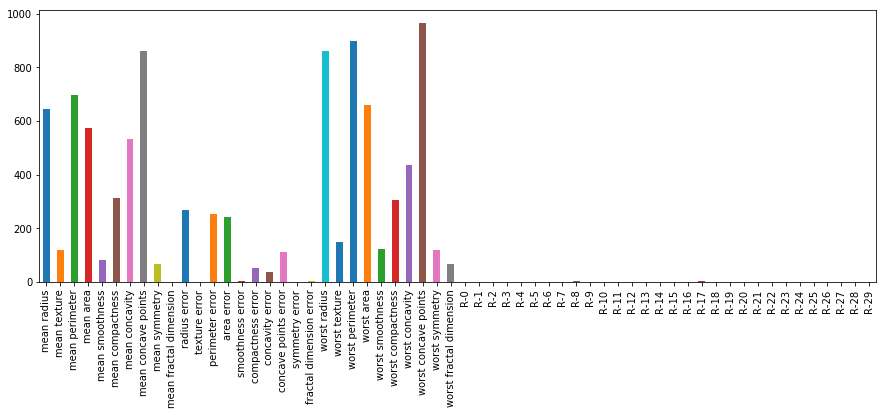

In [7]:
# EJERCICIO: mostrar el grado de relevancia de cada atributo del datastet X_ruidosos mediante el test ANOVA
t_anova1 = f_classif(X_ruidosos, y)
muestra_relevancias(X_ruidosos.columns,t_anova1[0])

In [8]:
# EJERCICIO: mostrar la selección de la primera mitad de atributos (el 50% mejor) para X según el test ANOVA
selector1 = SelectPercentile(score_func=f_classif, percentile=50).fit(X,y).get_support()
muestra_seleccion(X.columns,selector1)

15 ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [9]:
# EJERCICIO: mostrar la selección de la primera mitad de atributos (el 50% mejor) para X_ruidosos según el test ANOVA
selector2 = SelectPercentile(score_func=f_classif,percentile=50).fit(X_ruidosos,y).get_support()
muestra_seleccion(X_ruidosos.columns,selector2)

30 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'radius error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'R-8', 'R-16', 'R-17']


In [10]:
# EJERCICIO: mostrar la selección de los 10 mejores atributos para X según el test ANOVA
selector3 = SelectKBest(score_func=f_classif,k=10).fit(X_ruidosos,y).get_support()
muestra_seleccion(X_ruidosos.columns,selector3)

10 ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


In [11]:
# EJERCICIO: 
#   - Obtener una matriz 'X_select' con los 30 mejores atributos del dataset 'X_ruidosos' según ANOVA
#   - Comparar el resultado de evaluar ambos datasets

X_select = X_ruidosos[['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']]

print(evalua(X_ruidosos,y))
print(evalua(X_select,y))


0.9331669691470056
0.9472971221156339


### 1.2. Otros tests disponibles en Sklearn <a name="otros"> </a>
Además del test ANOVA que hemos visto en esta sección, Sklearn proporciona otras funciones de valoración de atributos tanto para tareas de clasificación como de regresión. Para clasificación, las funciones disponibles son:

- <code>f_classif</code>: valor-f del test ANOVA 
- <code>chi2</code>: test $\chi^2$ (solo para atributos positivos)
- <code>mutual_info_classif</code>: información mutua entre dos variables

Para regresión, por su parte, disponemos de estas funciones:

- <code>f_regression</code>: valor-f obtenido mediante regresión lineal
- <code>mutual_info_regression</code>: información mutua entre dos variables

[ True False  True  True False False  True  True False False False False
 False  True False False False False False False  True False  True  True
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[ True  True  True  True  True  True  True  True  True False  True False
  True  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False  True False  True False False False False False False False
 False False False False False False  True False  True False False False]
30 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'radius error', 'perimeter error', 'area error', 'compactness error', 'concavity error', 'concave points 

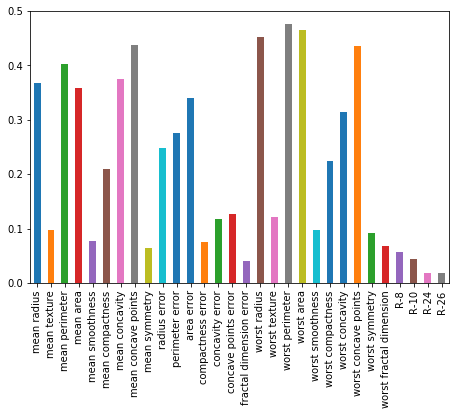

In [12]:
# EJERCICIO: realizar los siguientes ejercicios para X_ruidosos y mutual_info_classif
#    - mostrar la selección de los 10 mejores atributos
#    - mostrar la selección de la primera mitad de atributos
#    - obtener una matriz 'X_select' con los 30 mejores y comparar con el dataset original
#    - mostrar el grado de relevancia de cada atributo

# mostrar la selección de los 10 mejores atributos
selector4 = SelectKBest(score_func=mutual_info_classif,k=10).fit(X_ruidosos,y).get_support()
print(selector4)

# mostrar la selección de la primera mitad de atributos
selector5 = SelectPercentile(score_func=mutual_info_classif,percentile=50).fit(X_ruidosos,y).get_support()
print(selector5)
muestra_seleccion(X_ruidosos.columns,selector5)

# obtener una matriz 'X_select' con los 30 mejores y comparar con el dataset original
X_select = X_ruidosos[['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'radius error', 'perimeter error', 'area error', 'compactness error', 'concavity error', 'concave points error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'R-8', 'R-10', 'R-24', 'R-26']]
print(evalua(X_ruidosos,y))
print(evalua(X_select,y))

# mostrar el grado de relevancia de cada atributo
muestra_relevancias(X_select.columns, mutual_info_classif(X_select,y))

## 2. Selección de atributos basada en estimadores <a name="estimadores"> </a>

Algunos algoritmos de clasificación (y también de regresión), además de construir un modelo, son capaces de puntuar la importancia de los atributos al mismo tiempo. Esa puntuación es un buen indicador para determinar qué atributos seleccionar. Las dos familias de algoritmos que se suelen usar para esta técnica son:
- Algoritmos basados en árboles: la importancia se calcula sobre el número de veces que se usa cada atributo como criterio y la profundidad en la que aparecen en los árboles.
- Modelos lineales generalizados: la importancia se calcula a partir de los coeficientes aprendidos para cada atributo para construir el modelo.


### 2.1 Selección de atributos mediante árboles <a name="arboles"> </a>

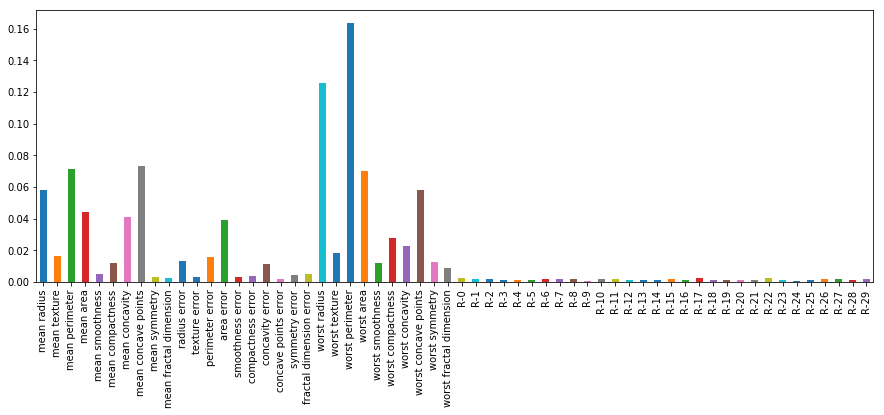

In [13]:
# EJERCICIO: mostrar la importancia de atributos calculada por un clasificador RandomForest
forest = RandomForestClassifier(n_estimators = 100, random_state=0)
forest.fit(X_ruidosos,y)
importances = forest.feature_importances_
muestra_relevancias(X_ruidosos.columns,importances)

In [14]:
# EJERCICIO: mostrar los atributos seleccionados por SelectFromModel sobre el clasificador RFC
#    - Usar como threshold la media de las importancias de atributos
seleccionados = SelectFromModel(forest,threshold='mean').fit(X_ruidosos,y).get_support()
seleccionados_attribs = X_ruidosos.columns[seleccionados]
muestra_seleccion(X_ruidosos.columns,seleccionados)

13 ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [15]:
# EJERCICIO: mostrar los atributos seleccionados por SelectFromModel sobre el clasificador RFC
#    - Usar como threshold la mitad de la media de las importancias de atributos
seleccionados = SelectFromModel(forest,threshold='0.5*mean').fit(X_ruidosos,y).get_support()
seleccionados_attribs = X_ruidosos.columns[seleccionados]
muestra_seleccion(X_ruidosos.columns,seleccionados)

21 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'concavity error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [16]:
# EJERCICIO: mostrar los atributos seleccionados por SelectFromModel sobre el clasificador RFC
#    - Usar como threshold la mediana de las importancias de atributos
seleccionados = SelectFromModel(forest,threshold='median').fit(X_ruidosos,y).get_support()
seleccionados_attribs = X_ruidosos.columns[seleccionados]
muestra_seleccion(X_ruidosos.columns,seleccionados)

30 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'R-17']


In [17]:
# EJERCICIO: usar el anterior selector construido mediante SelectFromModel para obtener una versión reducida 'X_ruidosos'
#    - Guardar el resultado en X_seleccion
#    - Mostrar los 'shapes' de ambas matrices
X_seleccion = X_ruidosos[['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'R-17']]
print(X_ruidosos.shape)
print(X_seleccion.shape)

(569, 60)
(569, 30)


In [18]:
# EJERCICIO: Evaluación de los datasets X_ruidosos y X_seleccion
print(evalua(X_ruidosos,y))
print(evalua(X_seleccion,y))

0.9331669691470056
0.9491152450090743


### 2.2. Selección de atributos mediante coeficientes de modelos lineales <a name="coeficientes"> </a>

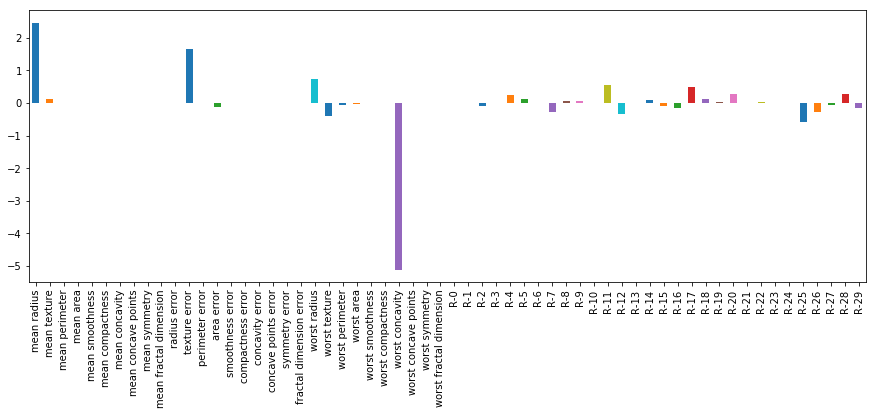

In [19]:
# EJERCICIO: mostrar los coeficientes de los atributos calculados por LogisticRegression con regularización 'l1'
lr = LogisticRegression(solver = 'liblinear', penalty = 'l1', random_state=0)
lr.fit(X_ruidosos,y)
importances = lr.coef_
muestra_relevancias(X_ruidosos.columns,importances[0])

In [20]:
# EJERCICIO: mostrar los atributos seleccionados por SelectFromModel sobre el clasificador LR('l1')
#    - Usar como threshold la mediana de las importancias de atributos

seleccionados = SelectFromModel(lr,threshold='median').fit(X_ruidosos,y).get_support()
seleccionados_attribs = X_ruidosos.columns[seleccionados]
muestra_seleccion(X_ruidosos.columns,seleccionados)

30 ['mean radius', 'mean texture', 'texture error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concavity', 'R-2', 'R-4', 'R-5', 'R-7', 'R-8', 'R-9', 'R-11', 'R-12', 'R-14', 'R-15', 'R-16', 'R-17', 'R-18', 'R-19', 'R-20', 'R-22', 'R-25', 'R-26', 'R-27', 'R-28', 'R-29']


In [21]:
# EJERCICIO: usar el anterior selector para obtener una selección de 'X_ruidosos'
#    - Guardar el resultado en X_seleccion
#    - Mostrar los 'shapes' de ambas matrices
#    - Evaluar ambos datasets

X_seleccion = X_ruidosos[['mean radius', 'mean texture', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'texture error', 'perimeter error', 'worst radius', 'worst texture', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'R-4', 'R-5', 'R-7', 'R-11', 'R-12', 'R-14', 'R-17', 'R-18', 'R-20', 'R-23', 'R-25', 'R-26', 'R-27', 'R-28', 'R-29']]
print(X_ruidosos.shape)
print(X_seleccion.shape)
print(evalua(X_ruidosos,y))
print(evalua(X_seleccion,y))

(569, 60)
(569, 30)
0.9331669691470056
0.9331680494339297


### 2.3 Pipelines para encadenar selección y clasificación <a name="pipelines"> </a>

Mediante los pipelines se pueden encadenar estimadores que se entrenan de forma conjunta. Si hacemos un <code>predict</code> sobre un pipeline, para los $n-1$ primeros estimadores se aplicará <code>transform</code> y para el último <code>predict</code>.

Los pipelines se comportan a todos los efectos como estimadores pudiéndose, por ejemplo, realizar validación cruzada sobre ellos con <code>cross_val_predict</code> o <code>cross_val_score</code>.

In [22]:
# EJERCICIO: consrtuir un pipeline con los siguientes componentes:
#    - Un selector sobre RFC y usando la mediana como threshold
#    - Un clasificador LogisticRegression
# Evaluar usando X_ruidosos como dataset y el pipeline como clasificador

selector = SelectFromModel(forest,threshold='median')
lr_cl = LogisticRegression(solver='liblinear', random_state=0)
pipeline = Pipeline(memory=None, steps=[('selector', selector),('lr', lr_cl)])
evalua(X_ruidosos,y,pipeline)

0.9561327888687234

In [23]:
# EJERCICIO: consrtuir un pipeline con los siguientes componentes:
#    - Un selector sobre LogisticRegression usando la mediana como threshold
#    - Un clasificador RFC
# Evaluar usando X_ruidosos como dataset y el pipeline como clasificador

selector = SelectFromModel(lr_cl,threshold='median')
forest = RandomForestClassifier(n_estimators=100,random_state=0)
pipeline = Pipeline(memory=None, steps=[('selector', selector),('forest', forest)])
evalua(X_ruidosos,y,pipeline)

0.9631524933022211

## 3. Extracción de atributos mediante _análisis de componentes principales_ <a name="pca"> </a>

El análisis de componentes principales es es una técnica que permite describir un dataset en términos de nuevos atributos (los componentes) que no estén correlacionados. Cada una de estas nuevas columnas se ordenan por la cantidad de varianza que captura de los datos originales, y esta importancia nos puede servir para quedarnos con un número más pequeño de características.


In [24]:
# EJERCICIO: transformar 'X' en 'X_pca_15' mediante PCA(n_components=15) y evaluar el nuevo conjunto de características
X_pca_15 = PCA(n_components=15).fit_transform(X)
evalua(X_pca_15,y)

0.9526240169388988

In [25]:
# EJERCICIO: transformar 'X_ruidosos' en 'X_ruidosos_pca_15' mediante PCA(n_components=15) y evaluar el nuevo conjunto de características
X_ruidosos_pca_15 = PCA(n_components=15).fit_transform(X_ruidosos)
evalua(X_ruidosos_pca_15,y)

0.942033964220897

In [26]:
# EJERCICIO: crear una función que pruebe el efecto de distintos valores de n_components (de 1 a un límite dado)
def evolucion_n_components(X, y, limite):
    ''' Aplica PCA con distintos valores de n_components a un dataset
    
    Entrada:
       - X: dataframe con los atributos
       - y: serie con la clase
       - limite: número máximo de n_components que se probará
    Salida:
       - Lista con los resultados de evaluar (con evalua_dataset) las distintas transformaciones probadas
    '''
    resultados = []
    for i in range(1,limite+1):
        X_pca_i = PCA(n_components=i).fit_transform(X)
        resultados.append(evalua(X_pca_i,y))
    return resultados
 

0.9491454930429521
0.957856926799758


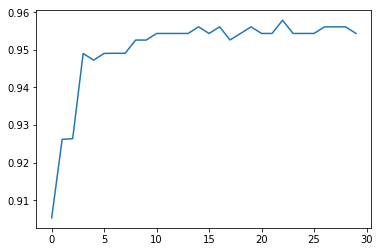

In [27]:
# TEST: de la función 'evolucion_n_components' sobre X
resultados = evolucion_n_components(X, y, len(X.columns))
print(evalua(X,y))
print(max(resultados))
plt.plot(resultados)

0.9331669691470056
0.94911416472215


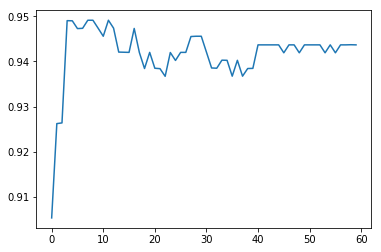

In [28]:
# TEST: de la función 'evolucion_n_components' sobre 'X_ruidosos'
resultados = evolucion_n_components(X_ruidosos, y, len(X_ruidosos.columns))
print(evalua(X_ruidosos,y))
print(max(resultados))
plt.plot(resultados)

In [33]:
# EJERCICIO: aplicar PCA(10) sobre X_ruidosos y mostrar la proporción de varianza capturada por cada componente
PCA(n_components=10).fit(X_ruidosos).explained_variance_ratio_



array([9.81980914e-01, 1.61755336e-02, 1.55752433e-03, 1.21033163e-04,
       8.84172176e-05, 6.84372407e-06, 4.35098676e-06, 3.06491070e-06,
       3.02211072e-06, 2.79537978e-06])

## 4. Selección de atributos por _eliminación recursiva_ <a name="rfe"> </a>

La eliminación recursiva de características (RFE de _recursive feature elimination_) se apoya en un clasificador base al igual que ocurre en la selección mediante importancia de atributos. En este caso los atributos se van descartando uno a uno, dejando fuera el que es peor en cada momento. Es una técnica computacionalmente un pocos costosa (el coste depende del clasificador base) pero suele dar buenos resultados.

In [39]:
# EJERCICIO: entrenar un selector RFE sobre X usando como clasificador base LogisticRegression
estimator = LogisticRegression(random_state=0, solver='liblinear')
selector = RFE(estimator).fit(X,y)

In [48]:
# EJERCICIO: guardar el ranking generado por RFE para X en ranking_X
ranking_X = selector.ranking_
ranking_X

array([ 1,  1,  2, 15,  3,  7,  1,  1,  1, 11, 12,  1,  1,  1, 13, 16,  4,
        9,  8, 14,  1,  1,  1, 10,  5,  1,  1,  1,  6,  1])

In [49]:
# Función para construir una lista ordenada de los nombres de atributos a partir de un ranking y su correspondiente matriz X
def ranking_nombres_atributos(ranking, X):
    posiciones_atributos = list(zip(ranking, list(X.columns)))
    posiciones_atributos.sort()
    return([a for _,a in posiciones_atributos])

In [50]:
# Calcular el diccionario de atributos para X
ranking_nombres_X = ranking_nombres_atributos(ranking_X, X)
print(ranking_nombres_X)

['area error', 'mean concave points', 'mean concavity', 'mean radius', 'mean symmetry', 'mean texture', 'perimeter error', 'texture error', 'worst compactness', 'worst concave points', 'worst concavity', 'worst fractal dimension', 'worst perimeter', 'worst radius', 'worst texture', 'mean perimeter', 'mean smoothness', 'concavity error', 'worst smoothness', 'worst symmetry', 'mean compactness', 'symmetry error', 'concave points error', 'worst area', 'mean fractal dimension', 'radius error', 'smoothness error', 'fractal dimension error', 'mean area', 'compactness error']


In [51]:
# EJERCICIO: definir una función que prueba el efecto de eliminar uno a uno los peores atributos de una matriz X
def evolucion_quitando_peor_atributo(X, y, ranking_nombres):
    ''' Quita uno a uno los peores atributos y evalua el dataset que va quedando
    
    Entrada:
       - X: dataframe con los atributos
       - y: serie con la clase
       - ranking_nombres: nombres de los atributos ordenados de mejor a peor
    Salida:
       - Lista con los resultados de evaluar (con evalua_dataset) las distintas versiones de X probadas
    '''


In [ ]:
# EJERCICIO: Evolución según RFE para X, mostrando:
#    - El resultado con todos los atributos
#    - El mejor resultado de la evolución
#    - La gráfica con la evolución


In [ ]:
# EJERCICIO: repetir todo el análisis hecho con X para la matriz X_ruidosos:
#    - Entrenar RFE y calcular el ranking de atributos
#    - Calcular el ranking de nombres
#    - Mostrar la evolución de los resultandos quitando atributos uno a uno (del peor al mejor)

# Entrenar RFE y calcular el ranking de atributos


# Calcular el ranking de nombres


# Mostrar la evolución de los resultandos quitando atributos uno a uno (del peor al mejor)


## 5. Conclusiones <a name="conclusiones"> </a>

Las técnicas han funcionado bien para los datos ruidosos (con una mejora máxima de 0.0288) pero no tanto para los datos originales:
- En el caso de los datos ruidosos sabíamos positivamente que había columnas que quitar, por lo que es razonable el resultado.
- Para los datos originanes estos resultados nos están sugiriendo que el conjunto de atributos originales era bastante bueno.

En cuanto a la utilidad y potencia de cada método, no podemos sacar conclusiones generales. En _machine learning_ impera la máxima _one size does not fit all_, y lo que funciona para un dataset no es seguro que funcione para otros.